# Example 4: Soil moisture retrieval with real data set

## 1. Narrative: Inversion of RT-models and Soil Moisture Retrieval

This notebook demonstrates a workflow for retrieving soil moisture (sm) from real-world radar backscatter data. The process involves:

- **Requirements**: Setting up the SenSE framework and necessary Python libraries.
- **Data Acquisition**: Fetching preprocessed Sentinel-1 (radiometrically and geometrically corrected) and Sentinel-2 (atmospherically corrected) data.
- **Data Harmonization**: Aligning datasets in terms of spatial extent, pixel resolution, and temporal overlap.
- **Feature Extraction**: Calculating mean values for a specific agricultural field (Area of Interest).
- **Inversion**: Using Radiative Transfer (RT) model combinations to retrieve soil moisture.


## 2. Requirements

- Installation of SenSE
- Import packages

In [1]:
from pathlib import Path

import geopandas as gpd
from shapely.geometry import mapping

from pystac_client import Client
import planetary_computer as pc

import stackstac
import xarray as xr
import numpy as np
import pandas as pd

import rioxarray
import planetary_computer as pc
import stackstac
from shapely.geometry import box
from rasterio.enums import Resampling
import matplotlib.pyplot as plt

from sense.model import RTModel
from sense.soil import Soil
from sense.canopy import OneLayer
import matplotlib.pyplot as plt
from scipy.optimize import minimize


## 3. Data Acqusition

### 3.1 Load the Area of Interest (AOI) from a Shapefile

We define our study area by loading a vector shapefile representing field boundaries.

In [2]:
# This identifies the directory where your notebook is located
base_path = Path.cwd()

# Construct the path to the shapefile
shp_path = base_path / "data" / "MNI_2017.shp"

# Load shapefile
gdf = gpd.read_file(shp_path)

# Ensure WGS84 (required for STAC search)
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Use the first geometry as AOI
aoi_geom = mapping(gdf.geometry.iloc[0])

### 3.2 Connect to Planetary Computer STAC - Storage with preprocessed Sentinel-1 and Sentinel-2 data

We access the STAC (SpatioTemporal Asset Catalog) to retrieve preprocessed satellite imagery. Note: Direct Sentinel-1 retrieval via the stackstac library currently faces issues with missing Coordinate Reference System (CRS) metadata in certain STAC items.

In [3]:
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=pc.sign_inplace,
)

### 3.3.1 Sentinel-1 GRD (Sigma⁰, Terrain-Corrected) - ***Problem: no crs within the stac catalog - not working right now but maybe in the future***

In [4]:
# Search stac catalog
s1_search = catalog.search(
    collections=["sentinel-1-grd"],
    datetime="2017-03-01/2017-06-30",
    intersects=aoi_geom,
    query={
        "sar:instrument_mode": {"eq": "IW"},
    },
    max_items=100,  # IMPORTANT: avoids backend overload
)

s1_items = list(s1_search.get_items())

s1 = stackstac.stack(
    s1_items,
    assets=["vv"],
    epsg=32632,          
    resolution=10,
    bounds_latlon=gdf.total_bounds.tolist(),
    chunksize=2048,
)


/root/.local/lib/python3.12/site-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


### 3.3.2 Load Sentinel-1 Backscatter and Metadata from Local Files

**Since direct STAC stacking for S1 is currently limited, we load pre-clipped .npy datasets containing VV backscatter and incidence angle (θ) values.**

In [5]:
# 1. Extract metadata from the reference TIFF file to define spatial orientation
tif_ref = rioxarray.open_rasterio('data/clipped_reference.tif')

# Retrieve the bounding box in the TIFF's native coordinates (e.g., UTM)
# and transform it to WGS84 (EPSG:4326) for standardized spatial queries
bbox_4326 = tif_ref.rio.transform_bounds(4326)
aoi_geom = box(*bbox_4326) # Create a Shapely polygon from the transformed bounds

# 2. Prepare the Sentinel-1 SAR backscatter data as an xarray DataArray
# Load time stamps and backscatter values from local numpy files
time_s1 = pd.to_datetime(np.load('data/clipped_time.npy', allow_pickle=True))
vv_data = np.load('data/clipped_backscatter.npy')

s1_xr = xr.DataArray(
    vv_data,
    coords={"time": time_s1, "y": tif_ref.y, "x": tif_ref.x},
    dims=["time", "y", "x"]
).rio.write_crs(tif_ref.rio.crs)

# 3. Load incidence angle data (theta)
# Expected shape is (Time, Y, X)
inc_data = np.load('data/clipped_theta.npy') 

# Convert to a DataArray using the spatial coordinates from the reference TIFF
inc_xr = xr.DataArray(
    inc_data,
    coords={"time": time_s1, "y": tif_ref.y, "x": tif_ref.x},
    dims=["time", "y", "x"]
).rio.write_crs(tif_ref.rio.crs)

### 3.5 Sentinel-2 Level-2A (Atmospherically Corrected)

In [6]:
# 1. Search the STAC catalog for Sentinel-2 Level-2A imagery
s2_search = catalog.search(
    collections=["sentinel-2-l2a"],
    datetime="2017-03-01/2017-06-30",
    intersects=aoi_geom, 
    query={"eo:cloud_cover": {"lt": 20}},
)

# 2. Sign the items to authorize data access and prevent 403 errors
s2_items = [pc.sign(item) for item in s2_search.get_items()]

# 3. Create a data stack specifically aligned to the reference TIFF's properties
s2_stack = stackstac.stack(
    s2_items,
    assets=["B04", "B08"],   # Red and NIR bands required for NDVI calculation
    epsg=tif_ref.rio.crs.to_epsg(),
    resolution=tif_ref.rio.transform()[0], # Inherit pixel size from reference (e.g., 10m)
    bounds=tif_ref.rio.bounds(),          # Ensure exact spatial alignment with the TIFF
)

# 4. Calculate the Normalized Difference Vegetation Index (NDVI)
red = s2_stack.sel(band="B04").astype(float)
nir = s2_stack.sel(band="B08").astype(float)
ndvi = (nir - red) / (nir + red)

/root/.local/lib/python3.12/site-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


## 4. Harmonize Satellite Data

Ensure all datasets share the same spatial extent, pixel resolution, and temporal alignment for consistent model input.

In [7]:
# 1. Remove duplicate time stamps
# Group by 'time' and calculate the mean to handle overlapping satellite passes
ndvi_unique = ndvi.groupby("time").mean()

# 2. Interpolate NDVI values to match the Sentinel-1 acquisition timeline
ndvi_interp = ndvi_unique.interp(time=s1_xr.time, method="linear")

# 3. Combine variables into a unified Dataset and convert backscatter to decibels (dB)
ds = xr.Dataset({
    "backscatter_db": 10 * np.log10(s1_xr.where(s1_xr > 0)),
    "ndvi": ndvi_interp
})

In [8]:
# 1. Standardize SAR backscatter to a 10m resolution
# Bilinear resampling is used to ensure smooth transitions when scaling
s1_10m = s1_xr.rio.reproject(
    s1_xr.rio.crs, 
    resolution=10, 
    resampling=Resampling.bilinear
)

# 2. Reproject the incidence angle data to 10m resolution (consistent with backscatter)
inc_10m = inc_xr.rio.reproject(
    inc_xr.rio.crs, 
    resolution=10, 
    resampling=Resampling.bilinear
)

# 3. Align the NDVI stack to the 10m Sentinel-1 grid
# 'reproject_match' ensures pixel-for-pixel alignment between S2 and S1
ndvi_10m = ndvi_unique.rio.reproject_match(s1_10m)

# 4. Perform temporal interpolation on the harmonized grid
ndvi_interp = ndvi_10m.interp(time=s1_10m.time, method="linear")

# 5. Create the final harmonized 10m resolution Dataset
ds_10m = xr.Dataset({
    "backscatter_db": 10 * np.log10(s1_10m.where(s1_10m > 0)),
    "ndvi": ndvi_interp,
    "incidence_angle": inc_10m
})

print("Success: Dataset is now harmonized at 10m resolution.")

Success: Dataset is now harmonized at 10m resolution.


Confirmed Spatial Resolution: 10.0m x 10.0m


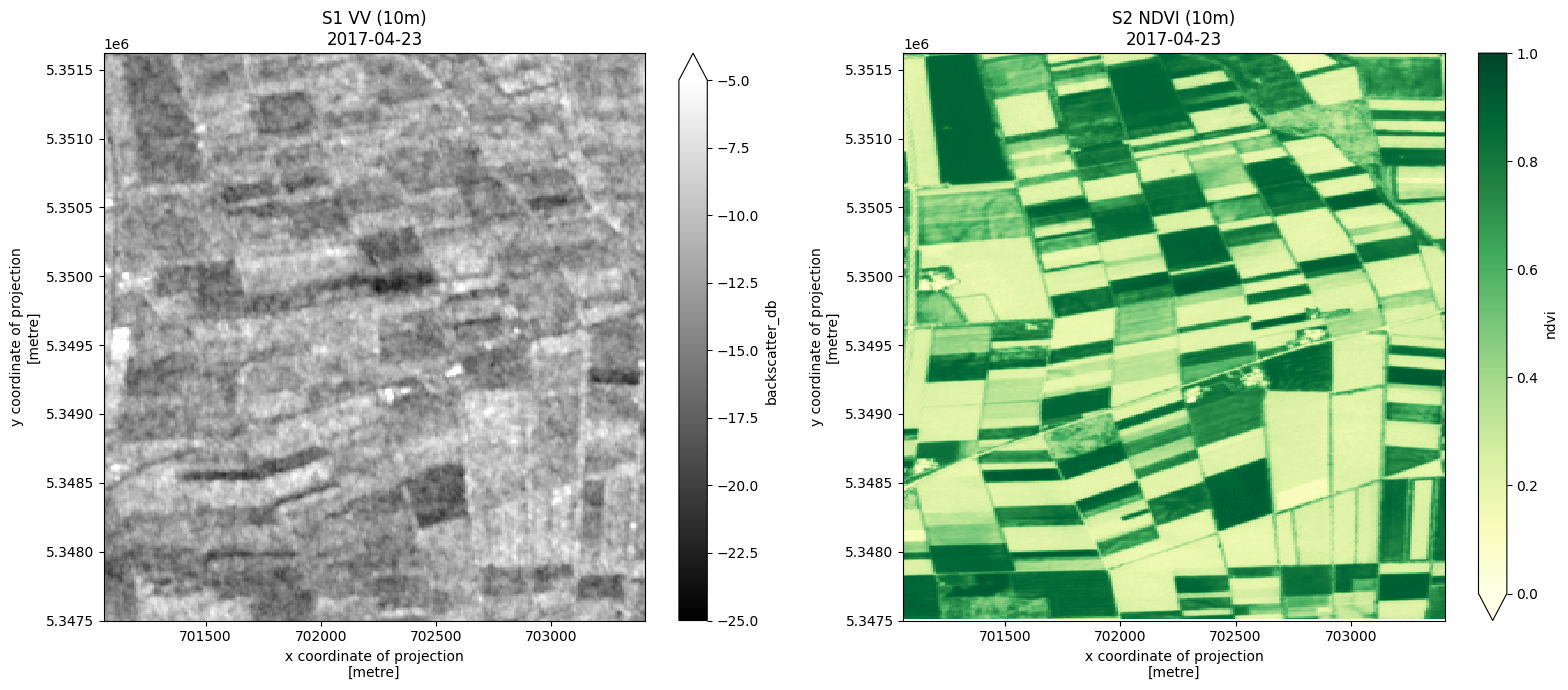

In [9]:
# --- Visual Data Inspection ---

# Select a specific time step (index 20) for visualization
t0 = ds_10m.isel(time=20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# 1. Plot Sentinel-1 Backscatter (VV)
# Using a grayscale colormap and typical SAR dB range (-25 to -5 dB)
t0.backscatter_db.plot(ax=ax1, cmap='gray', vmin=-25, vmax=-5)
ax1.set_title(f"S1 VV (10m)\n{str(t0.time.values)[:10]}")

# 2. Plot Sentinel-2 NDVI
# Using the Yellow-Green colormap to represent vegetation health
t0.ndvi.plot(ax=ax2, cmap='YlGn', vmin=0, vmax=1)
ax2.set_title(f"S2 NDVI (10m)\n{str(t0.time.values)[:10]}")

# 3. Verify pixel resolution
# Extract and print the resolution from the CRS metadata
res_y, res_x = ds_10m.rio.resolution()
print(f"Confirmed Spatial Resolution: {abs(res_x)}m x {abs(res_y)}m")

plt.tight_layout()
plt.show()

## 5. Feature Extraction Get data set for a specific area of interest (field based on shapefile)

Calculating mean values for a specific agricultural field (Area of Interest). Shapefile is provided.

In [10]:
# --- Vector Data Processing: Field Selection ---

# 1. Load the shapefile containing the field boundaries
fields_gdf = gpd.read_file('data/MNI_2017.shp')

# 2. Ensure the Coordinate Reference System (CRS) matches our raster data
# This step is critical for accurate spatial masking/clipping
fields_gdf = fields_gdf.to_crs(ds_10m.rio.crs)

# 3. Select a specific field of interest for analysis
# In this case, we filter by the 'NUMMER' attribute (Example ID: 542)
# Available field IDs in this dataset include: 515, 542, 508, 319, 301
single_field = fields_gdf[fields_gdf['NUMMER'] == 542]

# Display the attribute information for the selected field
print(single_field)


  ID  NUMMER  TEILNUM  NAME  FLAECHE BETRIEBSNU FRUCHTART       Frucht_lan  \
1  8     542        0  K 16     10.3         40        TR  Wintertriticale   

                                            geometry  
1  POLYGON ((703011.559 5351582.461, 703039.159 5...  


In [11]:
# --- Spatial Averaging and Parameter Extraction ---

# 1. Mask and clip the dataset (including incidence_angle) to the specific field boundary
# This ensures we only process pixels within our selected agricultural plot
field_clipped = ds_10m.rio.clip(single_field.geometry, single_field.crs)

# 2. Calculate the spatial mean for all variables (VV, NDVI, and Theta)
# This reduces the 2D grid to a 1D time-series representative of the whole field
field_mean = field_clipped.mean(dim=["x", "y"])

# 3. Convert backscatter from decibels (dB) back to linear scale
# Physical calculations and many RT models require linear units
vv_linear_xr = 10**(field_mean.backscatter_db / 10)

# 4. Synchronize data: Identify time steps where all three variables are valid
# This filters out dates where data might be missing (e.g., due to cloud cover in NDVI)
valid_indices = (
    field_mean.ndvi.notnull() & 
    field_mean.backscatter_db.notnull() & 
    field_mean.incidence_angle.notnull()
)

# 5. Extract final parameters for model input
# We apply the valid_indices filter and drop NaN entries to ensure clean arrays
vv = vv_linear_xr.where(valid_indices, drop=True).values
ndvi = field_mean.ndvi.where(valid_indices, drop=True).values
inc_deg = field_mean.incidence_angle.where(valid_indices, drop=True).values

# --- UNIT CONVERSION: Degrees to Radians ---
# Most trigonometric functions in Python (numpy) require input in radians
inc_rad = np.deg2rad(inc_deg) 

# 6. Extract and format the time axis
# Filtering the time coordinate to match our synchronized observations
vv_time = field_mean.time.where(valid_indices, drop=True).values 

# Convert the raw time values into flexible Pandas datetime objects
vv_time_datetime = pd.to_datetime(vv_time)

# --- Summary Output ---
print(f"Data synchronization complete. Total valid observations: {len(vv)}")


Data synchronization complete. Total valid observations: 59


### Visualization of synchronized field data

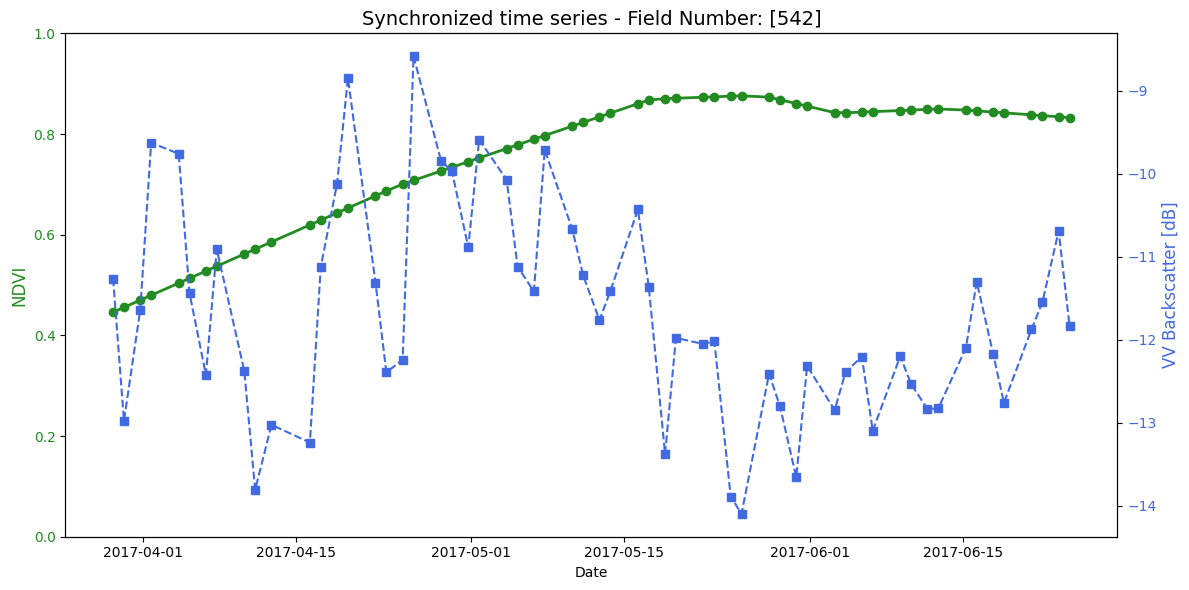

In [12]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# NDVI Plot
color_ndvi = 'forestgreen'
ax1.set_xlabel('Date')
ax1.set_ylabel('NDVI', color=color_ndvi, fontsize=12)
ax1.plot(vv_time_datetime, ndvi, color=color_ndvi, marker='o', linewidth=2, label='NDVI')
ax1.tick_params(axis='y', labelcolor=color_ndvi)
ax1.set_ylim(0, 1)

# Backscatter Plot
ax2 = ax1.twinx()
color_vv = 'royalblue'
ax2.set_ylabel('VV Backscatter [dB]', color=color_vv, fontsize=12)
ax2.plot(vv_time_datetime, 10 * np.log10(vv), color=color_vv, marker='s', linestyle='--', label='VV Radar')
ax2.tick_params(axis='y', labelcolor=color_vv)

# Titel und Layout
plt.title(f"Synchronized time series - Field Number: {str(single_field.NUMMER.values)}", fontsize=14)
fig.tight_layout()
plt.show()

## 6. Inversion 

Retrieval of soil moisture with RT-model combination **Oh92+WCM**

### 6.1 Parametrization

Define which RT models should be used (example combination of surface: Oh92 and canopy: SSRT)

In [13]:
# Choose models (surface: Oh92; canopy: watercloud)
#------------------------------------------------------------------
canopy = 'water_cloud' # other options are 'turbid_rayleigh' or 'water_cloud' 
surface = 'Oh92' # other options are 'Oh04", 'Dubois95', 'I2EM', 'WaterCloud'
models = {'surface' : surface, 'canopy' : canopy}
pol='vv' # use of Vertical-Vertical polarization due to its sensitivity to soil moisture

Define model parameters. For the parameter soil moisture (sm) a synthetic time series is created

In [14]:
# model parameter Oh92 (surface part)
#----------------------
freq = 5.405           # Frequency in GHz (C-band, typical for Sentinel-1)
s = 0.02              # Surface roughness (m)
clay = 0.0738          # Clay fraction (0-1)
sand = 0.2408          # Sand fraction (0-1)
bulk = 1.45            # Soil bulk density (g/cm3)
theta = inc_rad # Incidence angle in radians

# Generating a synthetic time series of soil moisture
sm_truth = np.random.uniform(low=0.05, high=0.35, size=(50,))

# model parameter watercloud (canopy part)
#---------------------
A_vv = 0.0950
A_hh = 0.1
A_hv = 0.1
B_vv = 0.5513
B_hh = 0.1 
B_hv = 0.1
V1 = ndvi*1
V2 = ndvi*1

### 6.2 Inversion

Define some helper function so that we can run the RT model in an inversion process. The aim is to provide backscatter to the RT model thus we can retrieve soil moisture values 

In [15]:
# Helper Functions for Soil Moisture Retrieval (Inversion)
# ---------------------------------------------------------

def run_model(dic, models):
    """
    Executes the Forward Radiative Transfer Model.
    This function takes physical parameters (soil moisture, roughness, vegetation)
    and simulates what the radar backscatter (sigma0) should look like.
    """
    
    # 1. Define Soil Properties: 
    # mv = volumetric soil moisture, s = surface roughness, f = frequency
    soil = Soil(mv=dic['mv'], s=dic['s'], clay=dic['clay'], 
                sand=dic['sand'], f=dic['f'], bulk=dic['bulk'])

    # 2. Define Canopy (Vegetation) Properties:
    # d = height, ke = extinction coefficient, omega = single scattering albedo
    # We calculate scattering coefficients (ks) based on the extinction and albedo.
    can = OneLayer(canopy=dic['canopy'], 
                   A_vv = dic['A_vv'],
                   A_hh = dic['A_hh'],
                   A_hv = dic['A_hv'],
                   B_vv = dic['B_vv'],
                   B_hh = dic['B_hh'],
                   B_hv = dic['B_hv'],
                   V1 = dic['V1'],
                   V2 = dic['V2'],
                   )

    # 3. Combine into the Radiative Transfer Model (RTModel):
    # theta = incidence angle of the satellite sensor
    S = RTModel(surface=soil, canopy=can, models=models, theta=dic['theta'], freq=dic['f'])
    
    # Run the simulation
    S.sigma0()
    
    # Return the total backscatter for VV and VH polarizations
    # Note: [::-1] is used here to ensure the dictionary key matches the internal naming
    return S.__dict__['stot']['vv'[::-1]], S.__dict__['stot']['vh'[::-1]]


def solve_fun(VALS, var_opt, dic, models):
    """
    Bridge function that updates the parameter dictionary with the 
    current 'guess' from the optimizer and runs the model.
    """
    for i in range(len(var_opt)):
        dic[var_opt[i]] = VALS[i]

    vv, vh = run_model(dic, models)
    return vv, vh


def fun_opt(VALS, var_opt, dic, models, pol):
    """
    The Objective (Cost) Function.
    This calculates the 'error' between the satellite observation and our model.
    The optimizer tries to minimize this value to find the true soil moisture.
    """
    
    # We use Least Squares (np.square) to penalize larger differences between 
    # the observed data (dic['vv']) and the simulated data (solve_fun(...)).
    
    if pol == 'vv':
        # Minimize error for VV polarization only
        return(np.nansum(np.square(solve_fun(VALS, var_opt, dic, models)[0]-dic['vv'])))
    
    elif pol == 'vh':
        # Minimize error for VH polarization only (often used for vegetation)
        return(np.nansum(np.square(solve_fun(VALS, var_opt, dic, models)[1]-dic['vh'])))
    
    elif pol == 'vv_vh':
        # Dual-polarization retrieval: seeks a balance that fits both VV and VH signals
        return(np.nansum(np.square((solve_fun(VALS, var_opt, dic, models)[0]-dic['vv'])/2 + 
                                   (solve_fun(VALS, var_opt, dic, models)[1]-dic['vh'])/2)))

Now we can run the inversion process to estimate soil moisture based on a synthetic radar backscatter time series

In [16]:
# Execution of the Soil Moisture Retrieval (Inversion Loop)
# ---------------------------------------------------------

# Initial Dictionary: Stores all constant physical and sensor parameters.
# These values (roughness, clay content, frequency, etc.) are held constant 
# while we solve for the unknown variable (soil moisture).
dic = {
    "mv": 0.2,      # Initial placeholder for soil moisture
    "s": s,         # Soil roughness (m)
    "clay": clay,   # Clay fraction
    "sand": sand,   # Sand fraction
    "f": freq,      # Radar frequency (GHz)
    "bulk": bulk,   # Soil bulk density
    "canopy": canopy, 
    "vv": vv,  # VV Polarization backscatter (Target)
    "vh": vv,  # VH Polarization backscatter
    "theta": theta, # Incidence angle
    "A_vv": A_vv,  # 
    "A_hh": A_hh,  # 
    "A_hv": A_hv,  # 
    "B_vv": B_vv,  # 
    "B_hh": B_hh,  # 
    "B_hv": B_hv,  # 
    "V1": ndvi,  # 
    "V1": ndvi,  # 
}

# Optimization Configuration
var_opt = ['mv']      # The variable we want to retrieve (Soil Moisture)
guess = [0.2]         # The starting point for the solver (20% moisture)
bounds = [(0.05, 0.35)] # Physical limits: prevents the solver from picking impossible values

# 'L-BFGS-B' is a common algorithm for "constrained" optimization.
# It is efficient for finding the minimum of a function within specific bounds.
method = 'L-BFGS-B'

# List to store the results for each time-step or pixel
sm_retrieved = []

# Loop through each radar observation (Backscatter time-series or array)
for i, ii in enumerate(vv):
    
    # Update the dictionary with the specific observation for this iteration.
    # We feed the solver the exact backscatter (VV and VH) measured by the satellite.
    dic = {
        "mv": 0.2, "s": s, "clay": clay, "sand": sand, "f": freq, "bulk": bulk, 
        "canopy": canopy, "vv": vv[i], "vh": vv[i], 
        "theta": theta, "A_vv": A_vv, "A_hh": A_hh, "A_hv": A_hv, "B_vv": B_vv
        , "B_hh": B_hh, "B_hv": B_hv, "V1": ndvi[i], "V2": ndvi[i]
    }
    
    # The Minimize function:
    # It repeatedly calls 'fun_opt', adjusting the 'mv' value until the 
    # simulated backscatter matches the observed backscatter (vv[i]).
    res = minimize(fun_opt, guess, args=(var_opt, dic, models, pol), 
                   bounds=bounds, method=method)

    # Optional: Execute the function one last time with the optimized result 
    # to verify the final cost/error.
    fun_opt(res.x, var_opt, dic, models, 'vv')
    
    # Append the successful retrieval (res.x[0]) to our results list
    sm_retrieved.append(res.x[0])

# Result: 'sm_retrieved' now contains the estimated soil moisture values
# corresponding to your radar backscatter inputs.


### 6.3 Get in situ measurements

In [19]:
# --- In-situ Soil Moisture Data Processing ---

# 1. Load the raw CSV file
# Using header=[0, 1] to handle multi-level column indexing
df_raw = pd.read_csv('data/in_situ_s1.csv', header=[0, 1])

# 2. Identify the timestamp column
# Searching for the column with 'date' in the second-level header (case-insensitive)
date_col = [c for c in df_raw.columns if 'date' in str(c[1]).lower()][0]

# 3. Convert timestamps to datetime objects
# Providing an explicit format accelerates processing and prevents ParserWarnings
df_raw[date_col] = pd.to_datetime(
    df_raw[date_col], 
    format='%Y-%m-%d %H:%M:%S', 
    errors='coerce'
)

# 4. Filter out rows with invalid date formats (NaT)
df_raw = df_raw[df_raw[date_col].notnull()]

# 5. Set the timestamp as the DataFrame index for time-series operations
df_raw = df_raw.set_index(date_col)

# 6. Extract soil moisture (SM) values for each agricultural field
field_sm_data = {}
# Filter for actual field names (Level 0), ignoring unnamed/empty headers
field_names = [f for f in df_raw.columns.get_level_values(0).unique() if 'Unnamed' not in str(f)]

for field in field_names:
    # Check if the 'SM' sub-column exists for the current field
    if 'SM' in df_raw[field].columns:
        # Extract SM values and ensure they are floats; handle non-numeric errors
        sm_values = pd.to_numeric(df_raw[field]['SM'], errors='coerce')
        
        # Keep only valid numerical measurements
        sm_series = sm_values.dropna()
        
        if not sm_series.empty:
            field_sm_data[field] = sm_series

### 6.4 Visualization and model performance

**Current Status and Limitations:** The current parameterization of the Radiative Transfer (RT) model combination is in its initial phase. It is important to note that empirical and semi-empirical RT models often require site-specific calibration to account for local soil textures and specific crop architectures. This calibration step has not yet been implemented in this demonstration notebook. Consequently, the current retrieval results may show offsets compared to in-situ measurements. Future iterations of this framework will incorporate calibrated empirical parameters derived from extensive literature reviews and experimental validation to enhance retrieval accuracy.

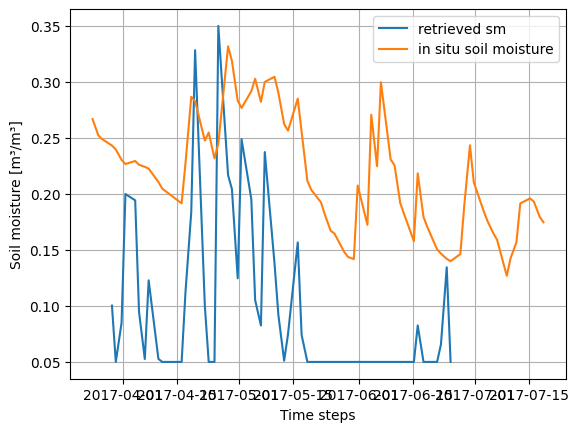

In [ ]:
# Visualization
# --------------
plt.plot(pd.to_datetime(vv_time_datetime), sm_retrieved, label='retrieved sm')
plt.plot(pd.to_datetime(field_sm_data['542_high'].index), field_sm_data['542_high'].values, label='in situ soil moisture')
plt.xlabel('Time steps')
plt.ylabel('Soil moisture [m³/m³]')
plt.grid()
plt.legend()